# Foundational Property Analysis of Koopman Walk Positional Encodings (KW-PE)

This notebook demonstrates the foundational property analysis of **Koopman Walk Positional Encodings (KW-PE)** on graph pairs from the expressiveness benchmark.

**Six analyses performed:**
1. **Nonlinear walk convergence** — behavior of tanh/softplus/ReLU walks on graph structures
2. **Custom EDMD implementation** — polynomial dictionary lifting for Koopman operator approximation
3. **Sign canonicality** — consistency of Koopman eigenfunctions across permutations and reruns
4. **Computational cost scaling** — KW-PE vs eigendecomposition timing
5. **EDMD numerical stability** — drift analysis across trajectory lengths
6. **Cospectral distinguishing test** — KW-PE vs RWPE baseline on non-isomorphic graph pairs

In [1]:
import subprocess, sys

def _install(packages):
    """Install packages only if not already importable."""
    missing = []
    for pkg in packages:
        name = pkg.split("==")[0].split(">=")[0].split("[")[0]
        try:
            __import__(name)
        except ImportError:
            missing.append(pkg)
    if missing:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", "-q"] + missing
        )

# --- Non-Colab packages (always install if missing) ---
_install(["loguru", "networkx"])

# --- Colab pre-installed packages: install only outside Colab ---
if "google.colab" not in sys.modules:
    _install([
        "numpy==1.26.4",
        "scipy==1.13.1",
        "matplotlib==3.9.2",
    ])

In [2]:
import gc
import json
import math
import os
import sys
import time
import warnings
from itertools import combinations_with_replacement
from pathlib import Path

import numpy as np
import scipy.linalg
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from loguru import logger

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Logging setup for notebook
logger.remove()
logger.add(sys.stdout, level="INFO", format="{time:HH:mm:ss}|{level:<7}|{message}")

1

## Data Loading

Load graph pairs from the expressiveness benchmark (GitHub URL with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e02dcd-breaking-the-spectral-invariance-ceiling/main/experiment_iter2_foundational_pr/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception:
        pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f:
            return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'][0]['examples'])} graph pairs")

Loaded 10 graph pairs


## Configuration

All tunable parameters for the experiment. Adjust these to trade off between speed and thoroughness.

In [5]:
# ── KW-PE default parameters ──
# Original values: DEFAULT_T=50, DEFAULT_D=16
DEFAULT_T = 15              # trajectory length for KW-PE
DEFAULT_D = 8               # number of Koopman eigenfunctions
DEFAULT_REG = 1e-8          # Tikhonov regularization
PROJ_DIM = 50               # random projection dimension for large graphs
DICT_DEGREE_THRESHOLD = 50  # use degree-2 for n <= this; else project+degree-2

# ── Convergence analysis ──
# Original values: CONVERGENCE_T=200, CONVERGENCE_MAX_NODES=20
CONVERGENCE_T = 50          # trajectory length for convergence study
CONVERGENCE_MAX_NODES = 5   # sample nodes for large graphs

# ── Sign canonicality ──
# Original values: SIGN_NUM_PERMS=30, SIGN_NUM_RERUNS=8, SIGN_NUM_GRAPHS=10
SIGN_NUM_PERMS = 3          # permutations per graph
SIGN_NUM_RERUNS = 4         # reruns for sign consistency
SIGN_NUM_GRAPHS = 2         # number of graphs to test

# ── Computational benchmarking ──
# Original values: BENCH_SIZES=[10, 50, 100, 500, 1000], BENCH_REPEATS=3
BENCH_SIZES = [10, 20, 30]  # graph sizes for timing (kept small; n>=50 with degree-2 dict is very expensive)
BENCH_REPEATS = 2           # repeats per size

# ── EDMD stability ──
# Original values: STABILITY_T_VALUES=[10, 20, 50, 100], STABILITY_REG_VALUES=[0.0, 1e-12, 1e-8, 1e-4]
STABILITY_T_VALUES = [5, 10, 20]
STABILITY_REG_VALUES = [1e-8, 1e-4]
STABILITY_DEGREES = [1, 2]

# ── Data processing ──
MAX_EXAMPLES = None  # None = all loaded examples

## Part 0: Data Parsing & Utility Functions

Parse the graph pairs from JSON format and define core utility functions for normalized adjacency computation and representative graph selection.

In [6]:
def load_dataset(data, max_examples=None):
    """Parse graph expressiveness benchmark dataset from loaded JSON."""
    examples = data["datasets"][0]["examples"]
    if max_examples is not None:
        examples = examples[:max_examples]
    logger.info(f"Parsing {len(examples)} examples")

    parsed = []
    for ex in examples:
        inp = json.loads(ex["input"])
        out = json.loads(ex["output"])
        parsed.append({
            "input_raw": ex["input"],
            "output_raw": ex["output"],
            "graph_A": inp["graph_A"],
            "graph_B": inp["graph_B"],
            "is_isomorphic": out["is_isomorphic"],
            "are_cospectral": out.get("are_cospectral", False),
            "metadata": {k: v for k, v in ex.items() if k.startswith("metadata_")},
        })
    return parsed


def adjacency_to_normalized(A):
    """Compute normalized adjacency: A_norm = D^{-1/2} A D^{-1/2}."""
    A = np.asarray(A, dtype=np.float64)
    deg = A.sum(axis=1)
    d_inv_sqrt = np.where(deg > 0, deg ** (-0.5), 0.0)
    A_norm = A * d_inv_sqrt[:, None] * d_inv_sqrt[None, :]
    return A_norm


def select_representative_graphs(examples, num_per_category=3):
    """Select representative graphs spanning categories and sizes."""
    by_category = {}
    for ex in examples:
        cat = ex["metadata"].get("metadata_category", "unknown")
        by_category.setdefault(cat, []).append(ex)

    selected = []
    for cat, exs in by_category.items():
        exs_sorted = sorted(exs, key=lambda e: e["graph_A"]["num_nodes"])
        indices = np.linspace(0, len(exs_sorted) - 1, min(num_per_category, len(exs_sorted)), dtype=int)
        for idx in indices:
            ex = exs_sorted[idx]
            pair_id = ex["metadata"].get("metadata_pair_id", f"unknown_{idx}")
            for label in ["graph_A", "graph_B"]:
                g = ex[label]
                selected.append({
                    "adj": np.array(g["adjacency_matrix"], dtype=np.float64),
                    "graph_id": f"{pair_id}_{label}",
                    "num_nodes": g["num_nodes"],
                    "category": cat,
                })
    logger.info(f"Selected {len(selected)} representative graphs across {len(by_category)} categories")
    return selected


# Parse data
examples = load_dataset(data, max_examples=MAX_EXAMPLES)
representative = select_representative_graphs(examples, num_per_category=2)
print(f"Parsed {len(examples)} pairs, selected {len(representative)} representative graphs")

16:30:14|INFO   |Parsing 10 examples


16:30:14|INFO   |Selected 20 representative graphs across 7 categories


Parsed 10 pairs, selected 20 representative graphs


## Part 1: Nonlinear Walk Implementation

Define nonlinear walk iteration: $x_{t+1} = \sigma(A_{\text{norm}} \cdot x_t)$ for different activation functions (tanh, softplus, ReLU). Classify convergence behavior (fixed point, limit cycle, slow decay).

In [7]:
def _stable_softplus(x):
    """Numerically stable softplus: log(1 + exp(x))."""
    return np.where(x > 20.0, x, np.log1p(np.exp(np.clip(x, -500, 20))))


NONLINEARITIES = {
    "tanh": np.tanh,
    "softplus": _stable_softplus,
    "relu": lambda x: np.maximum(x, 0.0),
}


def run_nonlinear_walk(A_norm, x0, sigma, T=200):
    """Iterate x_{t+1} = sigma(A_norm @ x_t) for T steps.
    Returns dict with trajectory info and convergence classification.
    """
    n = len(x0)
    trajectory = np.zeros((T + 1, n), dtype=np.float64)
    trajectory[0] = x0.copy()
    diffs = np.zeros(T, dtype=np.float64)

    for t in range(T):
        x_new = sigma(A_norm @ trajectory[t])
        if not np.all(np.isfinite(x_new)):
            return {
                "trajectory": trajectory[:t + 1], "diffs": diffs[:t],
                "converged": False, "convergence_time": T,
                "attractor_type": "divergence", "final_diff": float("inf"),
            }
        diffs[t] = np.linalg.norm(x_new - trajectory[t])
        trajectory[t + 1] = x_new

    final_diff = diffs[-1] if T > 0 else 0.0

    if final_diff < 1e-10:
        ct = int(np.argmax(diffs < 1e-10)) if np.any(diffs < 1e-10) else T
        return {
            "trajectory": trajectory, "diffs": diffs,
            "converged": True, "convergence_time": ct,
            "attractor_type": "fixed_point", "final_diff": float(final_diff),
        }

    for period in range(2, 11):
        if T > period:
            cycle_diff = np.linalg.norm(trajectory[-1] - trajectory[-1 - period])
            if cycle_diff < 1e-8:
                return {
                    "trajectory": trajectory, "diffs": diffs,
                    "converged": True, "convergence_time": T,
                    "attractor_type": f"limit_cycle_period_{period}", "final_diff": float(final_diff),
                }

    if final_diff < 0.01:
        return {
            "trajectory": trajectory, "diffs": diffs,
            "converged": False, "convergence_time": T,
            "attractor_type": "slow_decay", "final_diff": float(final_diff),
        }

    return {
        "trajectory": trajectory, "diffs": diffs,
        "converged": False, "convergence_time": T,
        "attractor_type": "no_convergence", "final_diff": float(final_diff),
    }

print("Nonlinear walk functions defined.")

Nonlinear walk functions defined.


## Part 2: Custom EDMD Implementation

Extended Dynamic Mode Decomposition (EDMD) with polynomial dictionary lifting. The dictionary maps state vectors to a higher-dimensional feature space for better Koopman operator approximation.

In [8]:
def polynomial_dictionary(x, degree=2):
    """Lift n-dimensional state x to polynomial features up to given degree."""
    if degree == 1:
        return x.copy()
    features = [x]
    n = len(x)
    if degree >= 2:
        outer = np.outer(x, x)
        idx_upper = np.triu_indices(n)
        features.append(outer[idx_upper])
    if degree >= 3:
        cubic = []
        for idx in combinations_with_replacement(range(n), 3):
            cubic.append(np.prod(x[list(idx)]))
        features.append(np.array(cubic))
    return np.concatenate(features)


def _dictionary_dim(n, degree):
    """Compute dictionary dimension for given state dim and degree."""
    d = n
    if degree >= 2:
        d += n * (n + 1) // 2
    if degree >= 3:
        d += (n * (n + 1) * (n + 2)) // 6
    return d


def _lift_trajectory_batch(trajectory, degree, proj_matrix=None):
    """Vectorized lifting of a trajectory (T+1, n) -> (T+1, D)."""
    if proj_matrix is not None:
        trajectory = trajectory @ proj_matrix.T
    if degree == 1:
        return trajectory.copy()
    T_plus_1, state_dim = trajectory.shape
    parts = [trajectory]
    if degree >= 2:
        idx_i, idx_j = np.triu_indices(state_dim)
        quad = trajectory[:, idx_i] * trajectory[:, idx_j]
        parts.append(quad)
    return np.hstack(parts)


def edmd_fit(trajectories, dictionary_fn, dictionary_dim, regularization=1e-8,
             degree=2, proj_matrix=None):
    """Fit EDMD from multiple trajectory data using vectorized operations."""
    D = dictionary_dim
    all_psi_x, all_psi_y = [], []

    for traj in trajectories:
        T_steps = len(traj) - 1
        if T_steps < 1:
            continue
        lifted = _lift_trajectory_batch(traj, degree=degree, proj_matrix=proj_matrix)
        all_psi_x.append(lifted[:-1])
        all_psi_y.append(lifted[1:])

    if not all_psi_x:
        return {
            "eigenvalues": np.zeros(D, dtype=np.complex128),
            "eigenvectors": np.eye(D, dtype=np.complex128),
            "K_edmd": np.zeros((D, D)), "condition_number": float("inf"),
        }

    Psi_X = np.vstack(all_psi_x)
    Psi_Y = np.vstack(all_psi_y)
    M = Psi_X.shape[0]

    G = (Psi_X.T @ Psi_X) / M
    A_mat = (Psi_X.T @ Psi_Y) / M
    del Psi_X, Psi_Y, all_psi_x, all_psi_y

    cond_G = np.linalg.cond(G) if np.all(np.isfinite(G)) else float("inf")

    try:
        K_edmd = np.linalg.solve(G + regularization * np.eye(D), A_mat)
    except np.linalg.LinAlgError:
        G_reg = G + regularization * np.eye(D)
        U, s, Vt = np.linalg.svd(G_reg, full_matrices=False)
        threshold = 1e-6 * s.max() if len(s) > 0 and s.max() > 0 else 1e-12
        s_inv = np.where(s > threshold, 1.0 / s, 0.0)
        K_edmd = (Vt.T * s_inv) @ U.T @ A_mat

    if not np.all(np.isfinite(K_edmd)):
        return {
            "eigenvalues": np.zeros(D, dtype=np.complex128),
            "eigenvectors": np.eye(D, dtype=np.complex128),
            "K_edmd": np.zeros((D, D)), "condition_number": float(cond_G),
        }

    eigenvalues, eigenvectors = np.linalg.eig(K_edmd)
    idx = np.argsort(-np.abs(eigenvalues))
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    return {
        "eigenvalues": eigenvalues, "eigenvectors": eigenvectors,
        "K_edmd": K_edmd, "condition_number": float(cond_G),
    }

print("EDMD functions defined.")

EDMD functions defined.


## Part 3: KW-PE Computation Pipeline

Full KW-PE pipeline: normalized adjacency → nonlinear walks → EDMD → Koopman eigenfunctions → positional encodings.

In [9]:
def compute_kwpe(A, sigma_name="tanh", T=50, d=16, dictionary_degree=2,
                  regularization=1e-8, proj_dim=PROJ_DIM, rng=None):
    """Full KW-PE computation pipeline for a single graph."""
    if rng is None:
        rng = np.random.default_rng(42)
    sigma = NONLINEARITIES[sigma_name]
    A = np.asarray(A, dtype=np.float64)
    n = A.shape[0]
    t_start = time.perf_counter()

    A_norm = adjacency_to_normalized(A)

    use_projection = n > DICT_DEGREE_THRESHOLD and dictionary_degree >= 2
    if use_projection:
        actual_proj_dim = min(proj_dim, n)
        proj_matrix = rng.standard_normal((actual_proj_dim, n)) / np.sqrt(actual_proj_dim)
        state_dim = actual_proj_dim
    else:
        proj_matrix = None
        state_dim = n

    actual_degree = dictionary_degree
    D = _dictionary_dim(state_dim, actual_degree)

    if D > 2000:
        actual_degree = 1
        D = state_dim

    def dict_fn(x):
        if proj_matrix is not None:
            x = proj_matrix @ x
        return polynomial_dictionary(x, degree=actual_degree)

    t_walk_start = time.perf_counter()
    trajectories = []

    if n > 80:
        node_indices = rng.choice(n, size=min(80, n), replace=False)
    else:
        node_indices = np.arange(n)

    for i in node_indices:
        x0 = np.zeros(n, dtype=np.float64)
        x0[i] = 1.0
        traj_data = run_nonlinear_walk(A_norm, x0, sigma, T=T)
        trajectories.append(traj_data["trajectory"])

    t_walk = time.perf_counter() - t_walk_start

    t_edmd_start = time.perf_counter()
    edmd_result = edmd_fit(
        trajectories, dict_fn, D, regularization=regularization,
        degree=actual_degree, proj_matrix=proj_matrix,
    )
    t_edmd = time.perf_counter() - t_edmd_start

    eigenvalues = edmd_result["eigenvalues"]
    eigenvectors = edmd_result["eigenvectors"]
    actual_d = min(d, D)

    PE = np.zeros((n, actual_d), dtype=np.float64)
    for i in range(n):
        e_i = np.zeros(n, dtype=np.float64)
        e_i[i] = 1.0
        psi_i = dict_fn(e_i)
        for j in range(actual_d):
            PE[i, j] = np.real(eigenvectors[:, j].conj() @ psi_i)

    t_total = time.perf_counter() - t_start

    return {
        "PE": PE, "eigenvalues": eigenvalues[:actual_d],
        "condition_number": edmd_result["condition_number"],
        "walk_time_s": t_walk, "edmd_time_s": t_edmd, "total_time_s": t_total,
        "dictionary_dim": D, "dictionary_degree": actual_degree,
        "used_projection": use_projection, "nodes_sampled": len(node_indices),
    }

print("KW-PE pipeline defined.")

KW-PE pipeline defined.


## Part 4 & 5: RWPE Baseline and Distinguishing Test

RWPE computes random walk return probabilities as positional features. The distinguishing test compares whether KW-PE or RWPE can tell apart non-isomorphic graph pairs.

In [10]:
def compute_rwpe(A, k=16):
    """Compute Random Walk PE: p_i = [RW_{ii}, RW^2_{ii}, ..., RW^k_{ii}]."""
    A = np.asarray(A, dtype=np.float64)
    n = A.shape[0]
    deg = A.sum(axis=1)
    d_inv = np.where(deg > 0, 1.0 / deg, 0.0)
    RW = A * d_inv[None, :]

    PE = np.zeros((n, k), dtype=np.float64)
    RW_power = np.eye(n, dtype=np.float64)

    for step in range(k):
        RW_power = RW_power @ RW
        PE[:, step] = np.diag(RW_power)

    return PE


def pe_signature(PE, tol=1e-6):
    """Convert PE matrix to a sorted multiset signature for comparison."""
    PE_rounded = np.round(PE / tol) * tol
    norms = np.linalg.norm(PE_rounded, axis=1)
    idx = np.lexsort((*PE_rounded.T, norms))
    sorted_pe = PE_rounded[idx]
    return [tuple(row) for row in sorted_pe]


def check_distinguished(PE_A, PE_B, tol=1e-5):
    """Check if two PE multisets are different (graphs distinguished)."""
    if PE_A.shape[0] != PE_B.shape[0]:
        return True, float("inf")

    sig_A = pe_signature(PE_A, tol=tol)
    sig_B = pe_signature(PE_B, tol=tol)

    dist = 0.0
    for a, b in zip(sig_A, sig_B):
        diff = sum((ai - bi) ** 2 for ai, bi in zip(a, b))
        dist += diff ** 0.5

    distinguished = dist > tol * PE_A.shape[0] * 0.1
    return distinguished, float(dist)


def process_single_pair(idx, ex):
    """Process a single graph pair for distinguishing test."""
    metadata = ex["metadata"]
    result = {
        "idx": idx,
        "pair_id": metadata.get("metadata_pair_id", f"pair_{idx}"),
        "category": metadata.get("metadata_category", "unknown"),
    }

    try:
        A_A = np.array(ex["graph_A"]["adjacency_matrix"], dtype=np.float64)
        A_B = np.array(ex["graph_B"]["adjacency_matrix"], dtype=np.float64)
        n_A = ex["graph_A"]["num_nodes"]
        n_B = ex["graph_B"]["num_nodes"]

        kwpe_A = compute_kwpe(A_A, sigma_name="tanh", T=DEFAULT_T, d=DEFAULT_D,
                              dictionary_degree=2, regularization=DEFAULT_REG)
        kwpe_B = compute_kwpe(A_B, sigma_name="tanh", T=DEFAULT_T, d=DEFAULT_D,
                              dictionary_degree=2, regularization=DEFAULT_REG)

        if n_A == n_B:
            kwpe_dist, kwpe_distance = check_distinguished(kwpe_A["PE"], kwpe_B["PE"])
        else:
            kwpe_dist, kwpe_distance = True, float("inf")

        rwpe_A = compute_rwpe(A_A, k=DEFAULT_D)
        rwpe_B = compute_rwpe(A_B, k=DEFAULT_D)

        if n_A == n_B:
            rwpe_dist, rwpe_distance = check_distinguished(rwpe_A, rwpe_B)
        else:
            rwpe_dist, rwpe_distance = True, float("inf")

        result["kwpe_distinguished"] = bool(kwpe_dist)
        result["kwpe_distance"] = float(kwpe_distance)
        result["kwpe_cond"] = float(kwpe_A["condition_number"])
        result["kwpe_time_s"] = float(kwpe_A["total_time_s"] + kwpe_B["total_time_s"])
        result["rwpe_distinguished"] = bool(rwpe_dist)
        result["rwpe_distance"] = float(rwpe_distance)
        result["success"] = True

    except Exception as e:
        result["kwpe_distinguished"] = False
        result["kwpe_distance"] = 0.0
        result["kwpe_cond"] = float("inf")
        result["kwpe_time_s"] = 0.0
        result["rwpe_distinguished"] = False
        result["rwpe_distance"] = 0.0
        result["success"] = False
        result["error"] = str(e)[:200]

    return result

print("RWPE baseline and distinguishing test functions defined.")

RWPE baseline and distinguishing test functions defined.


## Phase 1: Convergence Analysis

Analyze how nonlinear walks converge on representative graphs. Tests tanh, softplus, and ReLU activations, tracking convergence rates and attractor types.

In [11]:
def convergence_analysis_single(graph_id, adj, num_nodes, sigma_name, T):
    """Run convergence analysis for a single graph + nonlinearity."""
    sigma = NONLINEARITIES[sigma_name]
    A = np.array(adj, dtype=np.float64)
    A_norm = adjacency_to_normalized(A)
    n = A.shape[0]

    rng = np.random.default_rng(42)
    if n > CONVERGENCE_MAX_NODES:
        test_nodes = rng.choice(n, size=CONVERGENCE_MAX_NODES, replace=False)
    else:
        test_nodes = np.arange(n)

    results = {
        "graph_id": graph_id, "num_nodes": num_nodes, "sigma": sigma_name,
        "nodes_tested": len(test_nodes), "convergence_times": [],
        "attractor_types": {}, "final_diffs": [],
    }

    for i in test_nodes:
        x0 = np.zeros(n, dtype=np.float64)
        x0[i] = 1.0
        walk_result = run_nonlinear_walk(A_norm, x0, sigma, T=T)

        at = walk_result["attractor_type"]
        results["attractor_types"][at] = results["attractor_types"].get(at, 0) + 1
        results["convergence_times"].append(walk_result["convergence_time"])
        results["final_diffs"].append(walk_result["final_diff"])

    if sigma_name == "tanh":
        x0 = np.zeros(n); x0[0] = 1.0
        walk = run_nonlinear_walk(A_norm, x0, np.tanh, T=T)
        x_final = walk["trajectory"][-1]
        z = A_norm @ x_final
        sech2 = 1.0 - np.tanh(z) ** 2
        J = np.diag(sech2) @ A_norm
        try:
            spec_radius = float(np.max(np.abs(np.linalg.eigvals(J))))
        except Exception:
            spec_radius = float("nan")
        results["jacobian_spectral_radius"] = spec_radius

    ct = results["convergence_times"]
    fd = results["final_diffs"]
    converged = sum(1 for d in fd if d < 1e-10 or d < 0.01)
    results["fraction_converged"] = converged / len(test_nodes) if len(test_nodes) > 0 else 0.0
    results["mean_convergence_time"] = float(np.mean(ct))

    x0 = np.zeros(n); x0[int(test_nodes[0])] = 1.0
    sample_walk = run_nonlinear_walk(A_norm, x0, sigma, T=min(T, 100))
    results["sample_trajectory_diffs"] = sample_walk["diffs"][:50].tolist()

    return results


def run_convergence_analysis(representative_graphs):
    """Run convergence analysis across representative graphs and nonlinearities."""
    logger.info("Starting convergence analysis...")
    t0 = time.perf_counter()

    # Limit to 6 small representative graphs for speed
    graphs_subset = [g for g in representative_graphs if g["num_nodes"] <= 10][:6]
    if not graphs_subset:
        graphs_subset = representative_graphs[:4]

    results_list = []
    for g in graphs_subset:
        for sigma_name in NONLINEARITIES:
            try:
                res = convergence_analysis_single(
                    g["graph_id"], g["adj"].tolist(), g["num_nodes"],
                    sigma_name, CONVERGENCE_T
                )
                results_list.append(res)
            except Exception as e:
                logger.debug(f"Convergence task failed: {e}")

    summary = {}
    for sigma_name in NONLINEARITIES:
        sigma_results = [r for r in results_list if r["sigma"] == sigma_name]
        if sigma_results:
            all_types = {}
            for r in sigma_results:
                for at, cnt in r["attractor_types"].items():
                    all_types[at] = all_types.get(at, 0) + cnt
            summary[sigma_name] = {
                "num_graphs": len(sigma_results),
                "overall_convergence_rate": float(np.mean([r["fraction_converged"] for r in sigma_results])),
                "mean_convergence_time": float(np.mean([r["mean_convergence_time"] for r in sigma_results])),
                "attractor_distribution": all_types,
            }

    tanh_results = [r for r in results_list if r["sigma"] == "tanh" and "jacobian_spectral_radius" in r]
    jacobian_analysis = {}
    if tanh_results:
        spec_radii = [r["jacobian_spectral_radius"] for r in tanh_results if np.isfinite(r["jacobian_spectral_radius"])]
        if spec_radii:
            jacobian_analysis = {
                "mean_spectral_radius": float(np.mean(spec_radii)),
                "max_spectral_radius": float(np.max(spec_radii)),
                "fraction_contractive": float(np.mean([1 for s in spec_radii if s < 1.0]) / len(spec_radii)),
            }

    elapsed = time.perf_counter() - t0
    logger.info(f"Convergence analysis done in {elapsed:.1f}s ({len(results_list)} results)")

    return {
        "summary": summary,
        "theoretical_jacobian_analysis": jacobian_analysis,
        "results_list": results_list,
    }


convergence_results = run_convergence_analysis(representative)
gc.collect()

# Print summary
for sigma, info in convergence_results["summary"].items():
    print(f"  {sigma}: convergence rate = {info['overall_convergence_rate']:.1%}, "
          f"mean time = {info['mean_convergence_time']:.1f}")
if convergence_results["theoretical_jacobian_analysis"]:
    j = convergence_results["theoretical_jacobian_analysis"]
    print(f"  Jacobian spectral radius (tanh): mean={j['mean_spectral_radius']:.4f}")

16:30:16|INFO   |Starting convergence analysis...


16:30:17|INFO   |Convergence analysis done in 1.8s (18 results)


  tanh: convergence rate = 100.0%, mean time = 50.0
  softplus: convergence rate = 0.0%, mean time = 50.0
  relu: convergence rate = 100.0%, mean time = 29.7
  Jacobian spectral radius (tanh): mean=0.9932


## Phase 2: Sign Canonicality Analysis

Test whether KW-PE eigenfunctions have canonical signs — checking equivariance under permutations and consistency across reruns.

In [12]:
def sign_canonicality_single_graph(graph_id, adj, sigma_name, num_perms, num_reruns):
    """Test sign canonicality for a single graph."""
    A = np.array(adj, dtype=np.float64)
    n = A.shape[0]
    d = min(DEFAULT_D, n)

    result = {"graph_id": graph_id, "sigma": sigma_name, "num_nodes": n}

    # Test 1: Equivariance
    rng = np.random.default_rng(123)
    equivariance_corrs = []
    equivariance_passed = True

    for perm_idx in range(num_perms):
        perm = rng.permutation(n)
        P = np.eye(n)[perm]
        A_perm = P @ A @ P.T

        kwpe_orig = compute_kwpe(A, sigma_name=sigma_name, T=DEFAULT_T, d=d,
                                  dictionary_degree=2, regularization=DEFAULT_REG,
                                  rng=np.random.default_rng(42))
        kwpe_perm = compute_kwpe(A_perm, sigma_name=sigma_name, T=DEFAULT_T, d=d,
                                  dictionary_degree=2, regularization=DEFAULT_REG,
                                  rng=np.random.default_rng(42))

        PE_orig = kwpe_orig["PE"]
        PE_perm = kwpe_perm["PE"]
        PE_orig_permuted = P @ PE_orig

        corrs = []
        for j in range(min(d, PE_orig.shape[1], PE_perm.shape[1])):
            v1 = PE_perm[:, j]
            v2 = PE_orig_permuted[:, j]
            if np.std(v1) < 1e-12 or np.std(v2) < 1e-12:
                corrs.append(1.0)
                continue
            c_pos = np.corrcoef(v1, v2)[0, 1] if len(v1) > 1 else 1.0
            c_neg = np.corrcoef(v1, -v2)[0, 1] if len(v1) > 1 else 1.0
            corrs.append(float(max(abs(c_pos), abs(c_neg)) if np.isfinite(c_pos) and np.isfinite(c_neg) else 0.0))

        equivariance_corrs.append(float(np.mean(corrs)) if corrs else 0.0)
        if np.mean(corrs) < 0.9:
            equivariance_passed = False

    result["equivariance_mean_corr"] = float(np.mean(equivariance_corrs)) if equivariance_corrs else 0.0
    result["equivariance_passed"] = equivariance_passed

    # Test 2: Sign consistency
    pe_runs = []
    for run_idx in range(num_reruns):
        rng_run = np.random.default_rng(run_idx * 1000 + 7)
        kwpe = compute_kwpe(A, sigma_name=sigma_name, T=DEFAULT_T, d=d,
                             dictionary_degree=2, regularization=DEFAULT_REG, rng=rng_run)
        pe_runs.append(kwpe["PE"])

    sign_consistent = 0
    sign_total = 0
    for i in range(len(pe_runs)):
        for j in range(i + 1, len(pe_runs)):
            for k in range(min(d, pe_runs[i].shape[1], pe_runs[j].shape[1])):
                v1 = pe_runs[i][:, k]
                v2 = pe_runs[j][:, k]
                if np.std(v1) < 1e-12 or np.std(v2) < 1e-12:
                    sign_consistent += 1
                    sign_total += 1
                    continue
                c = np.corrcoef(v1, v2)[0, 1]
                if np.isfinite(c) and abs(c) > 0.9:
                    if c > 0.9:
                        sign_consistent += 1
                sign_total += 1

    result["sign_canonical_fraction"] = float(sign_consistent / sign_total) if sign_total > 0 else 0.0
    return result


def run_sign_canonicality(examples):
    """Run sign canonicality comparison across nonlinearities."""
    logger.info("Starting sign canonicality analysis...")
    t0 = time.perf_counter()

    small_graphs = []
    for ex in examples:
        n = ex["graph_A"]["num_nodes"]
        if n <= 30 and len(small_graphs) < SIGN_NUM_GRAPHS:
            small_graphs.append({
                "adj": ex["graph_A"]["adjacency_matrix"],
                "graph_id": ex["metadata"].get("metadata_pair_id", "unknown") + "_A",
                "n": n,
            })

    if not small_graphs:
        return {"summary": {}}

    results_list = []
    for g in small_graphs:
        for sigma_name in NONLINEARITIES:
            try:
                res = sign_canonicality_single_graph(
                    g["graph_id"], g["adj"], sigma_name,
                    SIGN_NUM_PERMS, SIGN_NUM_RERUNS
                )
                results_list.append(res)
            except Exception as e:
                logger.debug(f"Sign canonicality task failed: {e}")

    summary = {}
    for sigma_name in NONLINEARITIES:
        sigma_results = [r for r in results_list if r["sigma"] == sigma_name]
        if sigma_results:
            summary[sigma_name] = {
                "equivariance_pass_rate": float(np.mean([r["equivariance_passed"] for r in sigma_results])),
                "mean_equivariance_corr": float(np.mean([r["equivariance_mean_corr"] for r in sigma_results])),
                "mean_sign_canonical_fraction": float(np.mean([r["sign_canonical_fraction"] for r in sigma_results])),
            }

    elapsed = time.perf_counter() - t0
    logger.info(f"Sign canonicality analysis done in {elapsed:.1f}s")

    return {"summary": summary}


sign_results = run_sign_canonicality(examples)
gc.collect()

for sigma, info in sign_results.get("summary", {}).items():
    print(f"  {sigma}: equivariance={info['equivariance_pass_rate']:.0%}, "
          f"sign consistency={info['mean_sign_canonical_fraction']:.2f}")

16:30:19|INFO   |Starting sign canonicality analysis...


16:30:42|INFO   |Sign canonicality analysis done in 22.8s


  tanh: equivariance=100%, sign consistency=1.00
  softplus: equivariance=100%, sign consistency=1.00
  relu: equivariance=100%, sign consistency=1.00


## Phase 3: Computational Cost Benchmarking

Compare KW-PE timing against eigendecomposition across different graph sizes to measure scaling exponents.

In [13]:
import networkx as nx


def generate_synthetic_graphs(sizes=None):
    """Generate synthetic random graphs for scaling analysis."""
    if sizes is None:
        sizes = BENCH_SIZES
    graphs = []
    rng = np.random.default_rng(42)

    for n in sizes:
        p = min(2 * np.log(n + 1) / max(n, 2), 0.9)
        for attempt in range(5):
            G = nx.erdos_renyi_graph(n, p, seed=int(rng.integers(0, 2**31)))
            if nx.is_connected(G):
                break
            p = min(p * 1.5, 0.95)
        A = nx.to_numpy_array(G, dtype=np.float64)
        graphs.append({"adj": A, "graph_type": "erdos_renyi", "n": n})

        if n >= 4:
            G_ba = nx.barabasi_albert_graph(n, min(3, n - 1), seed=int(rng.integers(0, 2**31)))
            A_ba = nx.to_numpy_array(G_ba, dtype=np.float64)
            graphs.append({"adj": A_ba, "graph_type": "barabasi_albert", "n": n})

    return graphs


def benchmark_single(n, graph_type, adj, T, d):
    """Benchmark a single graph for timing comparison."""
    A = np.array(adj, dtype=np.float64)
    result = {"n": n, "graph_type": graph_type, "T": T, "d": d}

    try:
        t0 = time.perf_counter()
        kwpe_result = compute_kwpe(A, sigma_name="tanh", T=T, d=d,
                                     dictionary_degree=2, regularization=DEFAULT_REG)
        kwpe_total = time.perf_counter() - t0
        result["kwpe_total_time_ms"] = kwpe_total * 1000
    except Exception:
        result["kwpe_total_time_ms"] = float("nan")

    try:
        L = np.diag(A.sum(axis=1)) - A
        t0 = time.perf_counter()
        np.linalg.eigh(L)
        result["eigendecomp_full_time_ms"] = (time.perf_counter() - t0) * 1000
    except Exception:
        result["eigendecomp_full_time_ms"] = float("nan")

    try:
        from scipy.sparse import csr_matrix
        from scipy.sparse.linalg import eigsh
        L_sparse = csr_matrix(np.diag(A.sum(axis=1)) - A)
        k_eig = min(d, n - 2) if n > d + 2 else max(1, n - 2)
        if k_eig >= 1 and n > 2:
            t0 = time.perf_counter()
            eigsh(L_sparse, k=k_eig, which='SM')
            result["eigendecomp_partial_time_ms"] = (time.perf_counter() - t0) * 1000
        else:
            result["eigendecomp_partial_time_ms"] = result.get("eigendecomp_full_time_ms", float("nan"))
    except Exception:
        result["eigendecomp_partial_time_ms"] = float("nan")

    return result


def run_computational_benchmark(synthetic_graphs):
    """Run computational cost benchmarking."""
    logger.info("Starting computational benchmarking...")
    t0 = time.perf_counter()

    results_list = []
    for g in synthetic_graphs:
        for rep in range(BENCH_REPEATS):
            try:
                res = benchmark_single(g["n"], g["graph_type"], g["adj"].tolist(),
                                        DEFAULT_T, DEFAULT_D)
                results_list.append(res)
            except Exception as e:
                logger.debug(f"Benchmark task failed: {e}")

    # Fit scaling exponents
    sizes_list = sorted(set(r["n"] for r in results_list))
    kwpe_times, eig_times = [], []
    for n in sizes_list:
        er_results = [r for r in results_list if r["n"] == n and r["graph_type"] == "erdos_renyi"]
        if er_results:
            kwpe_times.append(float(np.median([r.get("kwpe_total_time_ms", 1) for r in er_results])))
            eig_times.append(float(np.median([r.get("eigendecomp_full_time_ms", 1) for r in er_results])))

    kwpe_exponent, eig_exponent = 0.0, 0.0
    if len(sizes_list) >= 2 and len(kwpe_times) >= 2:
        log_n = np.log(np.array(sizes_list[:len(kwpe_times)], dtype=np.float64))
        log_kwpe = np.log(np.maximum(np.array(kwpe_times), 1e-6))
        log_eig = np.log(np.maximum(np.array(eig_times), 1e-6))
        try:
            kwpe_exponent = float(np.polyfit(log_n, log_kwpe, 1)[0])
        except Exception:
            pass
        try:
            eig_exponent = float(np.polyfit(log_n, log_eig, 1)[0])
        except Exception:
            pass

    elapsed = time.perf_counter() - t0
    logger.info(f"Computational benchmarking done in {elapsed:.1f}s")

    return {
        "summary": {
            "sizes_tested": sizes_list,
            "kwpe_scaling_exponent": kwpe_exponent,
            "eigendecomp_scaling_exponent": eig_exponent,
        },
        "results_list": results_list,
        "kwpe_times": kwpe_times,
        "eig_times": eig_times,
        "sizes_list": sizes_list,
    }


synthetic = generate_synthetic_graphs()
timing_results = run_computational_benchmark(synthetic)
gc.collect()

print(f"KW-PE scaling exponent: {timing_results['summary']['kwpe_scaling_exponent']:.2f}")
print(f"Eigendecomp scaling exponent: {timing_results['summary']['eigendecomp_scaling_exponent']:.2f}")

16:30:43|INFO   |Starting computational benchmarking...


16:31:17|INFO   |Computational benchmarking done in 33.5s


KW-PE scaling exponent: 2.34
Eigendecomp scaling exponent: -2.01


## Phase 4: EDMD Numerical Stability Analysis

Analyze condition numbers and eigenfunction drift across different trajectory lengths and regularization values to determine stable operating parameters.

In [14]:
def stability_analysis_single(graph_id, adj, sigma_name):
    """Analyze EDMD numerical stability for a single graph."""
    A = np.array(adj, dtype=np.float64)
    n = A.shape[0]

    result = {
        "graph_id": graph_id, "num_nodes": n, "sigma": sigma_name,
        "condition_numbers": {}, "eigenfunction_drift": {},
    }

    for degree in STABILITY_DEGREES:
        if n > 40 and degree >= 2:
            continue
        for T_val in STABILITY_T_VALUES:
            for reg in STABILITY_REG_VALUES:
                try:
                    kwpe = compute_kwpe(A, sigma_name=sigma_name, T=T_val,
                                         d=DEFAULT_D, dictionary_degree=degree,
                                         regularization=max(reg, 1e-15))
                    key = f"deg{degree}_T{T_val}_reg{reg}"
                    result["condition_numbers"][key] = kwpe["condition_number"]
                except Exception:
                    key = f"deg{degree}_T{T_val}_reg{reg}"
                    result["condition_numbers"][key] = float("inf")

    for T_val in STABILITY_T_VALUES:
        try:
            pe_T = compute_kwpe(A, sigma_name=sigma_name, T=T_val, d=DEFAULT_D,
                                 dictionary_degree=2, regularization=DEFAULT_REG)
            pe_T1 = compute_kwpe(A, sigma_name=sigma_name, T=T_val + 1, d=DEFAULT_D,
                                  dictionary_degree=2, regularization=DEFAULT_REG)

            d_used = min(pe_T["PE"].shape[1], pe_T1["PE"].shape[1])
            drifts = []
            for j in range(d_used):
                v1 = pe_T["PE"][:, j]
                v2 = pe_T1["PE"][:, j]
                if np.std(v1) < 1e-12 or np.std(v2) < 1e-12:
                    drifts.append(0.0)
                    continue
                c = np.corrcoef(v1, v2)[0, 1]
                drifts.append(1.0 - abs(c) if np.isfinite(c) else 1.0)

            result["eigenfunction_drift"][str(T_val)] = {
                "mean_drift": float(np.mean(drifts)),
                "max_drift": float(np.max(drifts)),
            }
        except Exception:
            result["eigenfunction_drift"][str(T_val)] = {
                "mean_drift": float("nan"), "max_drift": float("nan"),
            }

    return result


def run_stability_analysis(representative_graphs):
    """Run EDMD stability analysis across representative graphs."""
    logger.info("Starting EDMD stability analysis...")
    t0 = time.perf_counter()

    # Limit to 4 small graphs for speed
    graphs_to_test = [g for g in representative_graphs if g["num_nodes"] <= 10][:4]
    if not graphs_to_test:
        graphs_to_test = representative_graphs[:2]

    results_list = []
    for g in graphs_to_test:
        try:
            res = stability_analysis_single(g["graph_id"], g["adj"].tolist(), "tanh")
            results_list.append(res)
        except Exception as e:
            logger.debug(f"Stability task failed: {e}")

    all_drifts = {}
    for r in results_list:
        for T_str, drift_data in r["eigenfunction_drift"].items():
            all_drifts.setdefault(T_str, []).append(drift_data["mean_drift"])

    drift_threshold = STABILITY_T_VALUES[0]
    for T_str in sorted(all_drifts.keys(), key=lambda x: int(x)):
        finite_drifts = [d for d in all_drifts[T_str] if np.isfinite(d)]
        if finite_drifts and np.mean(finite_drifts) < 0.1:
            drift_threshold = int(T_str)
            break

    elapsed = time.perf_counter() - t0
    logger.info(f"Stability analysis done in {elapsed:.1f}s ({len(results_list)} results)")

    return {
        "summary": {
            "recommended_trajectory_length": drift_threshold,
            "recommended_regularization": DEFAULT_REG,
        },
        "all_drifts": all_drifts,
        "results_list": results_list,
    }


stability_results = run_stability_analysis(representative)
gc.collect()

print(f"Recommended T >= {stability_results['summary']['recommended_trajectory_length']}")
for T_str, drifts in stability_results["all_drifts"].items():
    finite = [d for d in drifts if np.isfinite(d)]
    if finite:
        print(f"  T={T_str}: mean drift = {np.mean(finite):.4f}")

16:31:19|INFO   |Starting EDMD stability analysis...


16:31:35|INFO   |Stability analysis done in 16.4s (4 results)


Recommended T >= 5
  T=5: mean drift = 0.0227
  T=10: mean drift = 0.0763
  T=20: mean drift = 0.0157


## Phase 5: Distinguishing Test — KW-PE vs RWPE

Process all graph pairs: compute KW-PE and RWPE for each pair, then check if the positional encodings distinguish the non-isomorphic graphs.

In [15]:
logger.info("Starting distinguishing test on all pairs...")
t_dist = time.perf_counter()

pair_results = []
for idx, ex in enumerate(examples):
    res = process_single_pair(idx, ex)
    pair_results.append(res)
    if (idx + 1) % 5 == 0:
        logger.info(f"  Processed {idx + 1}/{len(examples)} pairs...")

pair_results.sort(key=lambda r: r["idx"])
t_dist_elapsed = time.perf_counter() - t_dist
logger.info(f"Distinguishing test done in {t_dist_elapsed:.1f}s")

# Compute statistics
successful = [r for r in pair_results if r.get("success", False)]
kwpe_dist_count = sum(1 for r in successful if r["kwpe_distinguished"])
rwpe_dist_count = sum(1 for r in successful if r["rwpe_distinguished"])

# Per-category breakdown
category_stats = {}
for r, ex in zip(pair_results, examples):
    cat = ex["metadata"].get("metadata_category", "unknown")
    if cat not in category_stats:
        category_stats[cat] = {"total": 0, "successful": 0, "kwpe_dist": 0, "rwpe_dist": 0}
    category_stats[cat]["total"] += 1
    if r.get("success", False):
        category_stats[cat]["successful"] += 1
        if r["kwpe_distinguished"]:
            category_stats[cat]["kwpe_dist"] += 1
        if r["rwpe_distinguished"]:
            category_stats[cat]["rwpe_dist"] += 1

print(f"\nOverall: KW-PE {kwpe_dist_count}/{len(successful)}, RWPE {rwpe_dist_count}/{len(successful)}")
print("\nPer-category:")
for cat, stats in sorted(category_stats.items()):
    kwpe_rate = stats['kwpe_dist'] / max(stats['successful'], 1)
    rwpe_rate = stats['rwpe_dist'] / max(stats['successful'], 1)
    print(f"  {cat}: KW-PE {stats['kwpe_dist']}/{stats['successful']} ({kwpe_rate:.0%}), "
          f"RWPE {stats['rwpe_dist']}/{stats['successful']} ({rwpe_rate:.0%})")

16:31:36|INFO   |Starting distinguishing test on all pairs...


16:31:39|INFO   |  Processed 5/10 pairs...


16:31:44|INFO   |  Processed 10/10 pairs...


16:31:44|INFO   |Distinguishing test done in 8.0s



Overall: KW-PE 10/10, RWPE 8/10

Per-category:
  BREC_Basic: KW-PE 2/2 (100%), RWPE 2/2 (100%)
  BREC_Extension: KW-PE 2/2 (100%), RWPE 2/2 (100%)
  BREC_Regular: KW-PE 2/2 (100%), RWPE 2/2 (100%)
  BREC_Strongly_Regular: KW-PE 1/1 (100%), RWPE 0/1 (0%)
  CSL: KW-PE 1/1 (100%), RWPE 1/1 (100%)
  cospectral: KW-PE 1/1 (100%), RWPE 1/1 (100%)
  strongly_regular: KW-PE 1/1 (100%), RWPE 0/1 (0%)


## Results Visualization

Summary plots: (1) Convergence behavior across nonlinearities, (2) KW-PE vs RWPE distinguishing rates by category, (3) Computational scaling.

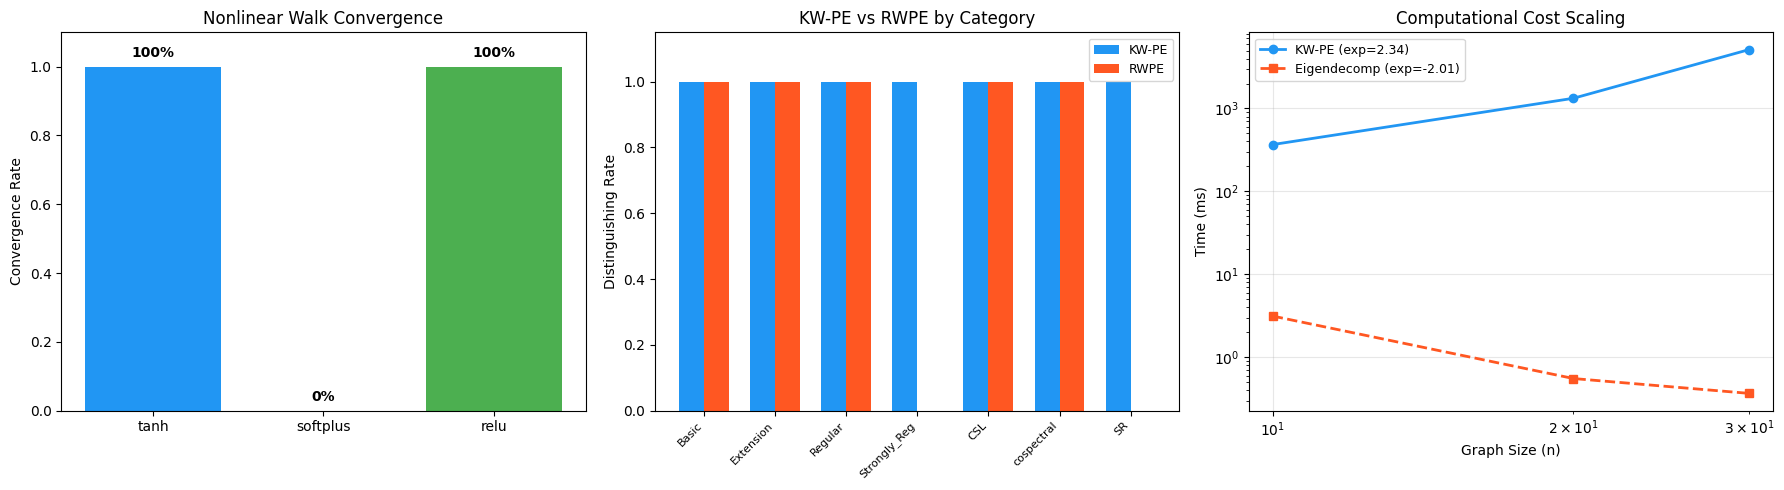

Results saved to kwpe_analysis_results.png


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Convergence rates by nonlinearity
ax = axes[0]
nonlin_names = list(convergence_results["summary"].keys())
conv_rates = [convergence_results["summary"][nl]["overall_convergence_rate"] for nl in nonlin_names]
colors = ['#2196F3', '#FF9800', '#4CAF50']
bars = ax.bar(nonlin_names, conv_rates, color=colors[:len(nonlin_names)])
ax.set_ylabel("Convergence Rate")
ax.set_title("Nonlinear Walk Convergence")
ax.set_ylim(0, 1.1)
for bar, rate in zip(bars, conv_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f"{rate:.0%}", ha='center', va='bottom', fontweight='bold')

# Plot 2: KW-PE vs RWPE per category
ax = axes[1]
cats = sorted(category_stats.keys())
kwpe_rates = [category_stats[c]["kwpe_dist"] / max(category_stats[c]["successful"], 1) for c in cats]
rwpe_rates = [category_stats[c]["rwpe_dist"] / max(category_stats[c]["successful"], 1) for c in cats]
x_pos = np.arange(len(cats))
width = 0.35
ax.bar(x_pos - width/2, kwpe_rates, width, label="KW-PE", color='#2196F3')
ax.bar(x_pos + width/2, rwpe_rates, width, label="RWPE", color='#FF5722')
ax.set_xticks(x_pos)
# Shorten category names
short_cats = [c.replace("BREC_", "").replace("strongly_regular", "SR")[:12] for c in cats]
ax.set_xticklabels(short_cats, rotation=45, ha='right', fontsize=8)
ax.set_ylabel("Distinguishing Rate")
ax.set_title("KW-PE vs RWPE by Category")
ax.legend(fontsize=9)
ax.set_ylim(0, 1.15)

# Plot 3: Computational scaling
ax = axes[2]
if timing_results["sizes_list"] and timing_results["kwpe_times"]:
    ax.loglog(timing_results["sizes_list"][:len(timing_results["kwpe_times"])],
              timing_results["kwpe_times"], 'o-', label=f"KW-PE (exp={timing_results['summary']['kwpe_scaling_exponent']:.2f})",
              color='#2196F3', linewidth=2)
    ax.loglog(timing_results["sizes_list"][:len(timing_results["eig_times"])],
              timing_results["eig_times"], 's--', label=f"Eigendecomp (exp={timing_results['summary']['eigendecomp_scaling_exponent']:.2f})",
              color='#FF5722', linewidth=2)
    ax.set_xlabel("Graph Size (n)")
    ax.set_ylabel("Time (ms)")
    ax.set_title("Computational Cost Scaling")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("kwpe_analysis_results.png", dpi=150, bbox_inches='tight')
plt.show()
print("Results saved to kwpe_analysis_results.png")